# Training ResNet on CIFAR-10
In this project, you will use the SimpleNN model to perform image classification on CIFAR-10. CIFAR-10 orginally contains 60K images from 10 categories. We split it into 45K/5K/10K images to serve as train/valiation/test set. We only release the ground-truth labels of training/validation dataset to you.

## Step 0: Set up the SimpleNN model
As you have practiced to implement simple neural networks in Homework 1, we just prepare the implementation for you.

In [1]:
# Run if on Colab

import os
import sys
from google.colab import drive

# Mount Drive
drive.mount('/content/drive')

# Path to your code
path = '/content/drive/My Drive/ECE661/Project'
print(os.listdir(path))
sys.path.append(path)

Mounted at /content/drive
['rotnet', 'rotnetmodel_epoch_20.pt', 'rotnetmodel_epoch_40.pt', 'rotnetmodel_epoch_60.pt', 'rotnetmodel_epoch_80.pt', 'rotnetmodel_epoch_100.pt', 'rotnetmodel_epoch_120.pt', 'rotnetmodel_epoch_140.pt', 'rotnetmodel_epoch_160.pt', 'rotnetmodel_epoch_180.pt', 'rotnetmodel_epoch_200.pt', 'mlp', 'mlp_base', '64bz']


In [2]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

# This code is more accurate for setting up the SimCLR model. It uses the predefined ResNet-50 and implements the necessary modifications.

In [3]:
from torchvision import models
import torch.nn as nn

# Set up Encoder
class Identity(nn.Module):
    def forward(self, x): return x

class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    # Use ResNet-50 Model as per paper
    self.resnet = models.resnet50(pretrained=True)

    # Make the SimCLR paper modifications
    self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.resnet.maxpool = Identity() # Replace maxpool with Identity
    self.resnet.fc = Identity()  # Remove fc with Identity

  def forward(self, x):
    return self.resnet(x)

In [ ]:
# Test Encoder
encoder = Encoder()
dummy_input = torch.randn(16, 3, 32, 32)  # batch of 16 CIFAR-10 images
output = encoder(dummy_input)
print(output.shape)  # should print torch.Size([16, 2048])

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 107MB/s]


torch.Size([16, 2048])


In [ ]:
# Set Up Projection Head
class ProjectionHead(nn.Module):
    def __init__(self, in_dim=2048, hidden_dim=2048, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, h):
        return self.net(h)

In [ ]:
# Test Projection Head
projection = ProjectionHead()
dummy_input = torch.randn(16, 2048)  # batch of 16 CIFAR-10 images
output = projection(dummy_input)
print(output.shape)  # should print torch.Size([16, 128]) if output_dim=128

torch.Size([16, 128])


In [ ]:
class SimCLR(nn.Module):
    def __init__(self, encoder, projection=None):
        super(SimCLR, self).__init__()

        self.encoder=encoder
        self.projection=projection

    def forward(self, x):
      out = self.encoder(x)

      if self.projection is not None:
        out = self.projection(out)
      return out

In [ ]:
# Test SimCLR Model
encoder = Encoder()
projection = ProjectionHead(in_dim=2048, hidden_dim=2048, out_dim=128)
dummy_input = torch.randn(16, 3, 32, 32)

# Training Phase (Both f(x) and g(x))
model = SimCLR(encoder=encoder, projection=projection)
output = model(dummy_input)
print(output.shape)  # Should be [16, 128]

# Testing Phase (Only f(x))
model = SimCLR(encoder=encoder, projection=None)
output = model(dummy_input)
print(output.shape)  # Should be [16, 2048]

torch.Size([16, 128])
torch.Size([16, 2048])


## Step 1: Set up preprocessing functions
Preprocessing is very important as discussed in the lecture.
You will need to write preprocessing functions with the help of *torchvision.transforms* in this step.
You can find helpful tutorial/API at [here](https://pytorch.org/vision/stable/transforms.html).

### Question (b)
For the question, you need to:
1. Complete the preprocessing code below.
2. **In the PDF report**, briefly describe what preprocessing operations you used and what are the purposes of them.

Hint:
1. Only two operations are necessary to complete the basic preprocessing here.
2. The raw input read from the dataset will be PIL images.
3. Data augmentation operations are not mendatory, but feel free to incorporate them if you want.
4. Reference value for mean/std of CIFAR-10 images (assuming the pixel values are within [0,1]): mean (RGB-format): (0.4914, 0.4822, 0.4465), std (RGB-format): (0.2023, 0.1994, 0.2010)

In [ ]:
# useful libraries
import torchvision
import torchvision.transforms as transforms

#############################################
# your code here
# specify preprocessing function
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(32),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)]),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),  std=(0.2023, 0.1994, 0.2010))
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])
#############################################

## Step 2: Set up dataset and dataloader

### Question (c)
Set up the train/val datasets and dataloders that are to be used during the training. Check out the [official API](https://pytorch.org/docs/stable/data.html) for more information about **torch.utils.data.DataLoader**.

Here, you need to:
1. Complete the code below.

In [ ]:
from torch.utils.data import Dataset

class SimCLRDataset(Dataset):
  def __init__(self, base_dataset, transform):
    self.base_dataset = base_dataset
    self.transform = transform

  def __getitem__(self, index):
    img, _ = self.base_dataset[index]
    xi = self.transform(img)
    xj = self.transform(img)
    return xi, xj

  def __len__(self):
    return len(self.base_dataset)

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100
base_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=None)
train_dataset = SimCLRDataset(base_dataset=base_dataset, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2)

100%|██████████| 170M/170M [00:05<00:00, 29.2MB/s]


In [ ]:
from time import time

start = time()
for i, (xi, xj) in enumerate(train_loader):
    if i == 5: break
end = time()
print(f"Time to load 5 batches: {end - start:.2f} seconds")


Time to load 5 batches: 2.53 seconds


In [ ]:
xi, xj = next(iter(train_loader))
print(xi.shape)
print(xj.shape)

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


## Step 3: Instantiate your SimpleNN model and deploy it to GPU devices.
### Question (d)
You may want to deploy your model to GPU device for efficient training. Please assign your model to GPU if possible. If you are training on a machine without GPUs, please deploy your model to CPUs.

Here, you need to:
1. Complete the code below.
2. **In the PDF report**, briefly describe how you verify that your model is indeed deployed on GPU. (Hint: check $\texttt{nvidia-smi}$.)

In [ ]:
# specify the device for computation
#############################################
# your code here
import torch


device = torch.device("cuda")
print(device)
!nvidia-smi
# import torch
# print(torch.__version__)  # Should show PyTorch version
# print(torch.cuda.is_available())  # Should return True
# print(torch.version.cuda)  # Should return 11.8
# print(torch.cuda.get_device_name(0))  # Should return your GPU name

#############################################

cuda
Sun Apr 20 23:39:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+

## Step 4: Set up the loss function and optimizer
Loss function/objective function is used to provide "feedback" for the neural networks. Typically, we use multi-class cross-entropy as the loss function for classification models. As for the optimizer, we will use SGD with momentum.

### Question (e)
Here, you need to:
1. Set up the cross-entropy loss as the criterion. (Hint: there are implemented functions in **torch.nn**)
2. Specify a SGD optimizer with momentum. (Hint: there are implemented functions in **torch.optim**)

In [ ]:
import torch.nn as nn
import torch.optim as optim

# hyperparameters, do NOT change right now
# initial learning rate
INITIAL_LR = 0.5

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

#############################################
# your code here
# create loss function
import torch
import torch.nn.functional as F

def nt_xent_loss(z_i, z_j, temperature=0.5):
    """
    Compute the NT-Xent (Normalized Temperature-scaled Cross Entropy) loss.

    Args:
        z_i: Tensor of shape [batch_size, projection_dim]
        z_j: Tensor of shape [batch_size, projection_dim]
        temperature: float, temperature scaling factor τ

    Returns:
        Scalar NT-Xent loss
    """

    N = z_i.size(0)                          # batch size
    z = torch.cat([z_i, z_j], dim=0)         # [2N, D]
    z = F.normalize(z, dim=1)                # L2 normalize each embedding vector

    # Cosine similarity matrix [2N, 2N]
    sim_matrix = torch.matmul(z, z.T)        # [2N, 2N] dot product since vectors are normalized
    sim_matrix = sim_matrix / temperature    # scale with τ

    # Remove similarity with itself (diagonal entries)
    mask = torch.eye(2 * N, device=z.device, dtype=torch.bool)
    sim_matrix = sim_matrix.masked_fill(mask, -1e4)

    # Positive pairs are at fixed offset: z_i[i] <-> z_j[i]
    positive_pairs = torch.cat([
        torch.arange(N, 2 * N),              # i in z_i -> j in z_j
        torch.arange(0, N)                   # j in z_j -> i in z_i
    ]).to(z.device)

    # Cross entropy loss: target is the index of the positive pair
    loss = F.cross_entropy(sim_matrix, positive_pairs)
    return loss

# Add optimizer
optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)
#############################################

## Step 5: Start the training process.

### Question (f)/(g)
Congratulations! You have completed all of the previous steps and it is time to train our neural network.

Here you need to:
1. Complete the training codes.
2. Actually perform the training.

Hint: Training a neural network usually repeats the following 4 steps:

**i) Get a batch of data from the dataloader and copy it to your device (GPU).**

**ii) Do a forward pass to get the outputs from the neural network and compute the loss. Be careful about your inputs to the loss function. Are the inputs required to be the logits or softmax probabilities?)**

**iii) Do a backward pass (back-propagation) to compute gradients of all weights with respect to the loss.**

**iiii) Update the model weights with the optimizer.**

You will also need to compute the accuracy of training/validation samples to track your model's performance over each epoch (the accuracy should be increasing as you train for more and more epochs).


In [ ]:
# some hyperparameters
# total number of training epochs
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()
EPOCHS = 30

# the folder where the trained model is saved
#Sam Path
# CHECKPOINT_FOLDER = '/content/drive/My Drive/ECE661/Project/checkpoints'

#Tony Path
CHECKPOINT_FOLDER = '/content/drive/My Drive/ECE 661/Project/checkpoints' #On Colab
# CHECKPOINT_FOLDER = './checkpoints' #On VS Code

def train_simclr_model(model, train_loader, EPOCHS, LR,
                       optimizer, nt_xent_loss, CHECKPOINT_FOLDER, model_name, device,
                       scaler=None, start_epoch=0, best_train_loss=float('inf')):

    if scaler is None:
        scaler = GradScaler()

    current_learning_rate = LR
    best_train_loss = float('inf')

    print("==> SimCLR Pretraining Starts!")
    print("="*50)

    for epoch in range(start_epoch, EPOCHS):
        model.train()
        total_loss = 0

        print("Epoch %d:" %epoch)
        for batch_idx, (xi, xj) in enumerate(train_loader):
          xi, xj = xi.to(device), xj.to(device)

          optimizer.zero_grad()

          with autocast():  #mixed precision magic here
              z_i = model(xi)
              z_j = model(xj)
              loss = nt_xent_loss(z_i, z_j)

          scaler.scale(loss).backward()       # backward with scaling
          scaler.step(optimizer)              # optimizer step
          scaler.update()                     # update scaling

          total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print("Training loss: %.4f" %(avg_loss))

        # Save best model (based on lowest training loss)
        if avg_loss < best_train_loss:
            best_train_loss = avg_loss
            if not os.path.exists(CHECKPOINT_FOLDER):
                os.makedirs(CHECKPOINT_FOLDER)
            print("Saving best model...")

            state = {
                'state_dict': model.state_dict(),
                'scaler': scaler.state_dict(),
                'epoch': epoch,
                'lr': current_learning_rate
            }
            filename = f"{model_name}_epoch{epoch}_trainloss{best_train_loss:.4f}_lr{current_learning_rate:.6f}.pth"
            filepath = os.path.join(CHECKPOINT_FOLDER, filename)
            torch.save(state, filepath)
            print(f"Model saved to {filepath}")

        if (epoch + 1) in list(range(20, 201, 20)):
            if not os.path.exists(CHECKPOINT_FOLDER):
                os.makedirs(CHECKPOINT_FOLDER)
            state = {
            'state_dict': model.state_dict(),
            'scaler': scaler.state_dict(),
            'epoch': epoch,
            'lr': current_learning_rate
            }
            filepath = os.path.join(CHECKPOINT_FOLDER, f"{model_name}_epoch{epoch+1}(128).pth")
            torch.save(state, filepath)

            print(f"Checkpoint saved at epoch {epoch+1}")

        print()

    print("="*50)
    print(f"==> Pretraining Finished! Best training loss: {best_train_loss:.4f}")


def reset(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        m.reset_parameters()

<ipython-input-24-5e94d93569ed>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


### Old Code

In [ ]:
# some hyperparameters
# total number of training epochs
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()
EPOCHS = 30

# the folder where the trained model is saved
#Sam Path
# CHECKPOINT_FOLDER = '/content/drive/My Drive/ECE661/Project/checkpoints'

#Tony Path
CHECKPOINT_FOLDER = '/content/drive/My Drive/ECE 661/Project/checkpoints' #On Colab
# CHECKPOINT_FOLDER = './checkpoints' #On VS Code

def train_simclr_model(model, train_loader, EPOCHS, LR,
                       optimizer, nt_xent_loss, CHECKPOINT_FOLDER, model_name, device,
                       scaler=None, start_epoch=0, best_train_loss=float('inf')):

    if scaler is None:
        scaler = GradScaler()

    current_learning_rate = LR
    best_train_loss = float('inf')

    print("==> SimCLR Pretraining Starts!")
    print("="*50)

    for epoch in range(start_epoch, EPOCHS):
        model.train()
        total_loss = 0

        print("Epoch %d:" %epoch)
        for batch_idx, (xi, xj) in enumerate(train_loader):
          xi, xj = xi.to(device), xj.to(device)

          optimizer.zero_grad()

          with autocast():  #mixed precision magic here
              z_i = model(xi)
              z_j = model(xj)
              loss = nt_xent_loss(z_i, z_j)

          scaler.scale(loss).backward()       # backward with scaling
          scaler.step(optimizer)              # optimizer step
          scaler.update()                     # update scaling

          total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print("Training loss: %.4f" %(avg_loss))

        # Save best model (based on lowest training loss)
        if avg_loss < best_train_loss:
            best_train_loss = avg_loss
            if not os.path.exists(CHECKPOINT_FOLDER):
                os.makedirs(CHECKPOINT_FOLDER)
            print("Saving best model...")

            state = {
                'state_dict': model.state_dict(),
                'epoch': epoch,
                'lr': current_learning_rate
            }
            filename = f"{model_name}_epoch{epoch}_trainloss{best_train_loss:.4f}_lr{current_learning_rate:.6f}.pth"
            filepath = os.path.join(CHECKPOINT_FOLDER, filename)
            torch.save(state, filepath)
            print(f"Model saved to {filepath}")

            if (epoch + 1) in [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]:
              if not os.path.exists(CHECKPOINT_FOLDER):
                  os.makedirs(CHECKPOINT_FOLDER)
              state = {
                  'state_dict': model.state_dict(),
                  'scaler': scaler.state_dict(),
                  'epoch': epoch,
                  'lr': current_learning_rate
              }
              filepath = os.path.join(CHECKPOINT_FOLDER, f"{model_name}_epoch{epoch+1}.pth")
              torch.save(state, filepath)
              print(f"Checkpoint saved at epoch {epoch+1}")

        print()

    print("="*50)
    print(f"==> Pretraining Finished! Best training loss: {best_train_loss:.4f}")


def reset(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        m.reset_parameters()

<ipython-input-16-ba0b076afd9b>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


## Base Model, No Tuning


In [ ]:
# Base SimCLR Model Training
encoder = Encoder()
projection = ProjectionHead()
model = SimCLR(encoder=encoder, projection=projection)
model = model.to(device)
model.apply(reset)
train_simclr_model(model=model, train_loader=train_loader, EPOCHS=30, LR=INITIAL_LR, optimizer=optimizer, nt_xent_loss=nt_xent_loss,
                   CHECKPOINT_FOLDER=CHECKPOINT_FOLDER, model_name="SimCLR_model", device=device)

### Code for Figure B.7

#### Helper Functions

In [ ]:
from torch.amp import autocast

def extractFeatures(dataloader, encoder):
    encoder.eval()
    features, labels = [], []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device, non_blocking=True)
            with autocast(device_type="cuda"):  # Mixed precision context
                outputs = encoder(images)

            outputs = outputs.float().cpu()  # Convert back to full float32, then move to CPU
            features.append(outputs)
            labels.append(targets)

    return torch.cat(features), torch.cat(labels)


Faster Version of extractFeatures

In [ ]:
from torch.cuda.amp import autocast

def extractFeatures(dataloader, encoder):
    features, labels = [], []
    encoder.eval()
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            with autocast():
                outputs = encoder(images)
            features.append(outputs.cpu())
            labels.append(targets)
    return torch.cat(features), torch.cat(labels)


In [ ]:
def trainLinearClassifier(train_features, train_labels, test_features, test_labels, batch_size, lr):

    classifier = nn.Linear(train_features.shape[1], 10).to(device)
    optimizer = optim.SGD(classifier.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    classifier.train()
    for epoch in range(20):
        for features_batch, labels_batch in train_loader:
            features_batch = features_batch.to(device)
            labels_batch = labels_batch.to(device)

            optimizer.zero_grad()
            outputs = classifier(features_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

    classifier.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for i in range(0, len(test_features), batch_size):
            features_batch = test_features[i:i+batch_size].to(device)
            labels_batch = test_labels[i:i+batch_size].to(device)

            outputs = classifier(features_batch)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels_batch).sum().item()
            total += labels_batch.size(0)

    accuracy = correct / total
    return accuracy

In [ ]:
def getEncoder(model):
    backbone = model.encoder.resnet
    encoder = nn.Sequential(
        backbone.conv1,
        backbone.bn1,
        backbone.relu,
        backbone.layer1,
        backbone.layer2,
        backbone.layer3,
        backbone.layer4,
        backbone.avgpool,
        nn.Flatten()
    ).to(device)
    encoder.eval()
    return encoder

In [ ]:
import csv
def save_results_to_csv(results, csvFile, LRs):
    with open(csvFile, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'BatchSize', 'LearningRate', 'Accuracy'])
        for epoch in results:
            for batchSize in results[epoch]:
                for idx, accuracy in enumerate(results[epoch][batchSize]):
                    lr = LRs[idx % len(LRs)]
                    writer.writerow([epoch, batchSize, lr, accuracy])
    print(f"Results saved to {csvFile}")

#### Define Dataloader for Linear Classifier

In [ ]:
import gc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

RuntimeError: invalid argument to reset_peak_memory_stats

In [ ]:
DATA_ROOT = '/content/data'
transform_eval = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

trainDataset = torchvision.datasets.CIFAR10(root=DATA_ROOT, train=True, download=True, transform=transform_eval)
testDataset = torchvision.datasets.CIFAR10(root=DATA_ROOT, train=False, download=True, transform=transform_eval)

trainLoaderEval = DataLoader(trainDataset, batch_size=256, shuffle=False, num_workers=2)
testLoaderEval = DataLoader(testDataset, batch_size=256, shuffle=False, num_workers=2)


#### New B.7 Code

In [ ]:
encoder = Encoder()
projection = ProjectionHead(in_dim=2048, hidden_dim=2048, out_dim=128)
model = SimCLR(encoder=encoder, projection=projection)
model = model.to(device)
model.apply(reset)
optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)

batchSizes = [256, 512, 1024, 2048, 4096]
epochs = list(range(50, 1001, 50))
LRs = [0.5, 1.0, 1.5]

results = {epoch: {batchSize: [] for batchSize in batchSizes} for epoch in epochs}

resultsFolder = '/content/drive/My Drive/ECE 661/Project/results' # On Colab
# resultsFolder = './results' # On VS Code
os.makedirs(resultsFolder, exist_ok=True)
csvFile = os.path.join(resultsFolder, 'linear_eval_results(128).csv')

current_learning_rate = INITIAL_LR
start_epoch = 0

train_simclr_model(
    model=model,
    train_loader=train_loader,
    EPOCHS=max(epochs),
    LR=current_learning_rate,
    optimizer=optimizer,
    nt_xent_loss=nt_xent_loss,
    CHECKPOINT_FOLDER=CHECKPOINT_FOLDER,
    model_name="SimCLR_Model",
    device=device,
    scaler=scaler,
    start_epoch=start_epoch,
    best_train_loss=float('inf')  # or load from checkpoint if you saved it
)

for numEpochs in epochs:
    checkpoint_path = f"{CHECKPOINT_FOLDER}/SimCLR_Model_epoch{numEpochs}(128).pth"
    model.load_state_dict(torch.load(checkpoint_path)['state_dict'], strict=False)
    model.eval()

    encoder = getEncoder(model)
    train_features, train_labels = extractFeatures(trainLoaderEval, encoder)
    test_features, test_labels = extractFeatures(testLoaderEval, encoder)

    for batchSize in batchSizes:
        # Change batch size of train_loader here
        train_loader_linear = DataLoader(
            trainDataset,
            batch_size=batchSize,
            shuffle=True,
            num_workers=2)

        for lr in LRs:
            top1Acc = trainLinearClassifier(train_features, train_labels, test_features, test_labels, batchSize, lr)
            results[numEpochs][batchSize].append(top1Acc)
    save_results_to_csv(results, csvFile, LRs)


NameError: name 'optim' is not defined

#### Old Loop to Get Data for Figure B.7

In [ ]:
batchSizes = [64, 128, 256, 512]
epochs = list(range(20, 201, 20))
LRs = [0.5, 1.0, 1.5]

results = {epoch: {batchSize: [] for batchSize in batchSizes} for epoch in epochs}

resultsFolder = '/content/drive/My Drive/ECE 661/Project/results' # On Colab
# resultsFolder = './results' # On VS Code
os.makedirs(resultsFolder, exist_ok=True)
csvFile = os.path.join(resultsFolder, 'linear_eval_results(updated).csv')

current_learning_rate = INITIAL_LR
start_epoch = 0

train_simclr_model(
    model=model,
    train_loader=train_loader,
    EPOCHS=max(epochs),
    LR=current_learning_rate,
    optimizer=optimizer,
    nt_xent_loss=nt_xent_loss,
    CHECKPOINT_FOLDER=CHECKPOINT_FOLDER,
    model_name="SimCLR_Model",
    device=device,
    scaler=scaler,
    start_epoch=start_epoch,
    best_train_loss=float('inf')  # or load from checkpoint if you saved it
)

for numEpochs in epochs:
    checkpoint_path = f"{CHECKPOINT_FOLDER}/SimCLR_Model_epoch{numEpochs}.pth"
    model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
    model.eval()

    encoder = getEncoder(model)
    train_features, train_labels = extractFeatures(trainLoaderEval, encoder)
    test_features, test_labels = extractFeatures(testLoaderEval, encoder)

    for batchSize in batchSizes:
        # Change batch size of train_loader here
        train_loader_linear = DataLoader(
            trainDataset,
            batch_size=batchSize,
            shuffle=True,
            num_workers=2)

        for lr in LRs:
            top1Acc = trainLinearClassifier(train_features, train_labels, test_features, test_labels, batchSize, lr)
            results[numEpochs][batchSize].append(top1Acc)
    save_results_to_csv(results, csvFile, LRs)


==> SimCLR Pretraining Starts!
Epoch 0:


<ipython-input-16-ba0b076afd9b>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  #mixed precision magic here


Training loss: 4.2690
Saving best model...
Model saved to /content/drive/My Drive/ECE 661/Project/checkpoints/SimCLR_Model_epoch0_trainloss4.2690_lr0.500000.pth

Epoch 1:
Training loss: 4.1216
Saving best model...
Model saved to /content/drive/My Drive/ECE 661/Project/checkpoints/SimCLR_Model_epoch1_trainloss4.1216_lr0.500000.pth

Epoch 2:
Training loss: 4.0762
Saving best model...
Model saved to /content/drive/My Drive/ECE 661/Project/checkpoints/SimCLR_Model_epoch2_trainloss4.0762_lr0.500000.pth

Epoch 3:
Training loss: 4.0351
Saving best model...
Model saved to /content/drive/My Drive/ECE 661/Project/checkpoints/SimCLR_Model_epoch3_trainloss4.0351_lr0.500000.pth

Epoch 4:
Training loss: 4.0099
Saving best model...
Model saved to /content/drive/My Drive/ECE 661/Project/checkpoints/SimCLR_Model_epoch4_trainloss4.0099_lr0.500000.pth

Epoch 5:
Training loss: 3.9847
Saving best model...
Model saved to /content/drive/My Drive/ECE 661/Project/checkpoints/SimCLR_Model_epoch5_trainloss3.9847

#### Code to start at saved epoch

In [ ]:
# ==== Setup ====
batchSizes = [64, 128, 256, 512]
epochs = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
LRs = [0.5, 1.0, 1.5]

results = {epoch: {batchSize: [] for batchSize in batchSizes} for epoch in epochs}

resultsFolder = '/content/drive/My Drive/ECE 661/Project/results'  # On Colab
os.makedirs(resultsFolder, exist_ok=True)
csvFile = os.path.join(resultsFolder, 'linear_eval_results(updated).csv')

# ==== Resume Training from epoch 120 ====

# Load checkpoint at epoch 120
start_epoch = 120
checkpoint_path = f"{CHECKPOINT_FOLDER}/SimCLR_Model_epoch{start_epoch}.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

model.load_state_dict(checkpoint['state_dict'])
scaler.load_state_dict(checkpoint['scaler'])
current_learning_rate = checkpoint['lr']

# Resume training function from epoch 120 onwards
train_simclr_model(
    model=model,
    train_loader=train_loader,
    EPOCHS=max(epochs),
    LR=current_learning_rate,
    optimizer=optimizer,
    nt_xent_loss=nt_xent_loss,
    CHECKPOINT_FOLDER=CHECKPOINT_FOLDER,
    model_name="SimCLR_Model",
    device=device,
    scaler=scaler,
    start_epoch=start_epoch
)

# ==== Linear Evaluation ====

for numEpochs in epochs:
    checkpoint_path = f"{CHECKPOINT_FOLDER}/SimCLR_Model_epoch{numEpochs}.pth"
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint {numEpochs} not found. Skipping.")
        continue

    print(f"\nLoading checkpoint for epoch {numEpochs}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()

    encoder = getEncoder(model)
    train_features, train_labels = extractFeatures(trainLoaderEval, encoder)
    test_features, test_labels = extractFeatures(testLoaderEval, encoder)

    for batchSize in batchSizes:
        train_loader_linear = DataLoader(
            trainDataset,
            batch_size=batchSize,
            shuffle=True,
            num_workers=2
        )

        for lr in LRs:
            top1Acc = trainLinearClassifier(
                train_features, train_labels,
                test_features, test_labels,
                batchSize, lr
            )
            results[numEpochs][batchSize].append(top1Acc)

    save_results_to_csv(results, csvFile, LRs)


#### Graph Code

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

csvPath = './results/linear_eval_results(Updated).csv'
file = pd.read_csv(csvPath)

grouped = file.groupby(['Epoch', 'BatchSize']).agg(
    mean_acc=('Accuracy', 'mean'),
    std_acc=('Accuracy', 'std')
).reset_index()

epochs = sorted(grouped['Epoch'].unique())
batch_sizes = sorted(grouped['BatchSize'].unique())
bar_width = 0.15
x = np.arange(len(epochs))

plt.figure(figsize=(12, 6))

for idx, batch_size in enumerate(batch_sizes):
    batch_data = grouped[grouped['BatchSize'] == batch_size]
    positions = x + idx * bar_width

    plt.bar(
        positions,
        batch_data['mean_acc'],
        width=bar_width,
        yerr=batch_data['std_acc'],
        capsize=3,
        label=f'Batch size {batch_size}'
    )

# Format plot
plt.xlabel('Training Epochs')
plt.ylabel('Top-1 Accuracy (%)')
plt.title('Linear Evaluation: Top-1 Accuracy vs Training Epochs')
plt.xticks(x + bar_width * (len(batch_sizes) - 1) / 2, epochs)
plt.legend(title='Batch Size')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## Linear Evaluation

BFGS Classifier

In [ ]:
def trainLinearClassifier(train_features, train_labels, test_features, test_labels, batch_size, lr):
    classifier = nn.Linear(train_features.shape[1], 10).to(device)
    optimizer = torch.optim.LBFGS(classifier.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Move full batch to device once
    train_features = train_features.to(device)
    train_labels = train_labels.to(device)

    classifier.train()
    for epoch in range(20):
        def closure():
            optimizer.zero_grad()
            outputs = classifier(train_features)
            loss = criterion(outputs, train_labels)
            loss.backward()
            return loss
        optimizer.step(closure)

    # Evaluation (can still use mini-batch if needed)
    classifier.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for i in range(0, len(test_features), batch_size):
            features_batch = test_features[i:i+batch_size].to(device)
            labels_batch = test_labels[i:i+batch_size].to(device)

            outputs = classifier(features_batch)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels_batch).sum().item()
            total += labels_batch.size(0)

    accuracy = correct / total
    return accuracy


In [ ]:
def parse_model_name(filename):
    filename = os.path.splitext(filename)[0]  # Remove .pth or .pt
    epoch = bs = lr = None

    for part in filename.split('_'):
        if 'epoch' in part and epoch is None:
            epoch = int(part.replace('epoch', '').split('.')[0])
        elif 'bs' in part and bs is None:
            bs = int(part.replace('bs', '').split('.')[0])
        elif 'lr' in part and lr is None:
            lr_str = part.replace('lr', '').split('.')[0] + '.' + part.replace('lr', '').split('.')[1]
            lr = float(lr_str)

    return epoch, bs, lr


In [ ]:
def append_result_to_csv(result_dict, csv_path):
    df = pd.DataFrame([result_dict])
    header = not os.path.exists(csv_path)  # Write header only if file doesn't exist
    # df.to_csv(csv_path, mode='a', header=header, index=False)

Linear Evaluation Loop

In [ ]:
import os

set1_folder = '/content/drive/My Drive/ECE661/Project/training_models/LR_Set1_0.5_0.25_0.125'


# TODO: Insert your model parsing and evaluation logic here
for root, dirs, files in os.walk(set1_folder):
  for file in files:
    print(file)
    if file.endswith('.pth') and 'epoch' in file and 'lr' in file and 'bs' in file:
      print(f"Found model: {os.path.join(root, file)}")
      epoch, batch_size, learning_rate = parse_model_name(file)
      print(f"Epoch: {epoch}, Batch Size: {batch_size}, Learning Rate: {learning_rate}")


SimCLR_bs64_epoch1_avg_loss4.5771_lr0.50.pth
Found model: /content/drive/My Drive/ECE661/Project/training_models/LR_Set1_0.5_0.25_0.125/epoch1/bs64/SimCLR_bs64_epoch1_avg_loss4.5771_lr0.50.pth
Epoch: 1, Batch Size: 64, Learning Rate: 0.5
SimCLR_bs64_epoch1_avg_loss4.4915_lr0.125.pth
Found model: /content/drive/My Drive/ECE661/Project/training_models/LR_Set1_0.5_0.25_0.125/epoch1/bs64/SimCLR_bs64_epoch1_avg_loss4.4915_lr0.125.pth
Epoch: 1, Batch Size: 64, Learning Rate: 0.125
SimCLR_bs64_lr0.25_epoch1.pth
Found model: /content/drive/My Drive/ECE661/Project/training_models/LR_Set1_0.5_0.25_0.125/epoch1/bs64/SimCLR_bs64_lr0.25_epoch1.pth
Epoch: 1, Batch Size: 64, Learning Rate: 0.25
SimCLR_bs64_epoch20_avg_loss3.7737_lr0.50.pth
Found model: /content/drive/My Drive/ECE661/Project/training_models/LR_Set1_0.5_0.25_0.125/epoch20/bs64/SimCLR_bs64_epoch20_avg_loss3.7737_lr0.50.pth
Epoch: 20, Batch Size: 64, Learning Rate: 0.5
SimCLR_bs64_epoch20_avg_loss3.5586_lr0.125.pth
Found model: /content/

In [ ]:
DATA_ROOT = '/content/data'
transform_eval = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

trainDataset = torchvision.datasets.CIFAR10(root=DATA_ROOT, train=True, download=True, transform=transform_eval)
testDataset = torchvision.datasets.CIFAR10(root=DATA_ROOT, train=False, download=True, transform=transform_eval)

trainLoaderEval = DataLoader(trainDataset, batch_size=256, shuffle=False, num_workers=2)
testLoaderEval = DataLoader(testDataset, batch_size=256, shuffle=False, num_workers=2)


In [ ]:
set1_folder = '/content/drive/My Drive/ECE661/Project/training_models/LR_Set1_0.5_0.25_0.125'
# results_csv_path = '/content/drive/My Drive/ECE 661/Project/eval_results.csv'

for root, dirs, files in os.walk(set1_folder):
    for file in files:
        if file.endswith('.pth') and 'epoch' in file and 'lr' in file and 'bs' in file:
            full_path = os.path.join(root, file)
            try:
                epoch, bs, lr = parse_model_name(file)
                print(f"Evaluating: {file} → epoch={epoch}, bs={bs}, lr={lr}")

                # Load model from checkpoint dict
                checkpoint = torch.load(full_path, map_location=device)

                encoder = Encoder()
                projection = ProjectionHead(in_dim=2048, hidden_dim=2048, out_dim=128)
                model = SimCLR(encoder=encoder, projection=projection).to(device)


                model.load_state_dict(checkpoint['state_dict'])
                model = model.to(device)

                encoder = getEncoder(model)

                # Extract features
                train_features, train_labels = extractFeatures(trainLoaderEval, encoder)
                test_features, test_labels = extractFeatures(testLoaderEval, encoder)

                # Train linear classifier
                acc = trainLinearClassifier(train_features, train_labels, test_features, test_labels, batch_size=bs, lr=0.1)
                print(f"Accuracy for epoch={epoch}, bs={bs}, lr={lr}: {acc}")

                # # Append result to CSV
                # result_row = {
                #     "learning_rate": lr,
                #     "epoch": epoch,
                #     "batch_size": bs,
                #     "accuracy": acc
                # }
                # append_result_to_csv(result_row, results_csv_path)

            except Exception as e:
                print(f"Skipping {file} due to error: {e}")


Evaluating: SimCLR_bs64_epoch1_avg_loss4.5771_lr0.50.pth → epoch=1, bs=64, lr=0.5
Accuracy for epoch=1, bs=64, lr=0.5: 0.3611
Evaluating: SimCLR_bs64_epoch1_avg_loss4.4915_lr0.125.pth → epoch=1, bs=64, lr=0.125
Accuracy for epoch=1, bs=64, lr=0.125: 0.4275
Evaluating: SimCLR_bs64_lr0.25_epoch1.pth → epoch=1, bs=64, lr=0.25
Accuracy for epoch=1, bs=64, lr=0.25: 0.3752
Evaluating: SimCLR_bs64_epoch20_avg_loss3.7737_lr0.50.pth → epoch=20, bs=64, lr=0.5
Accuracy for epoch=20, bs=64, lr=0.5: 0.6309
Evaluating: SimCLR_bs64_epoch20_avg_loss3.5586_lr0.125.pth → epoch=20, bs=64, lr=0.125
Accuracy for epoch=20, bs=64, lr=0.125: 0.7138
Evaluating: SimCLR_bs64_lr0.25_epoch20.pth → epoch=20, bs=64, lr=0.25


KeyboardInterrupt: 

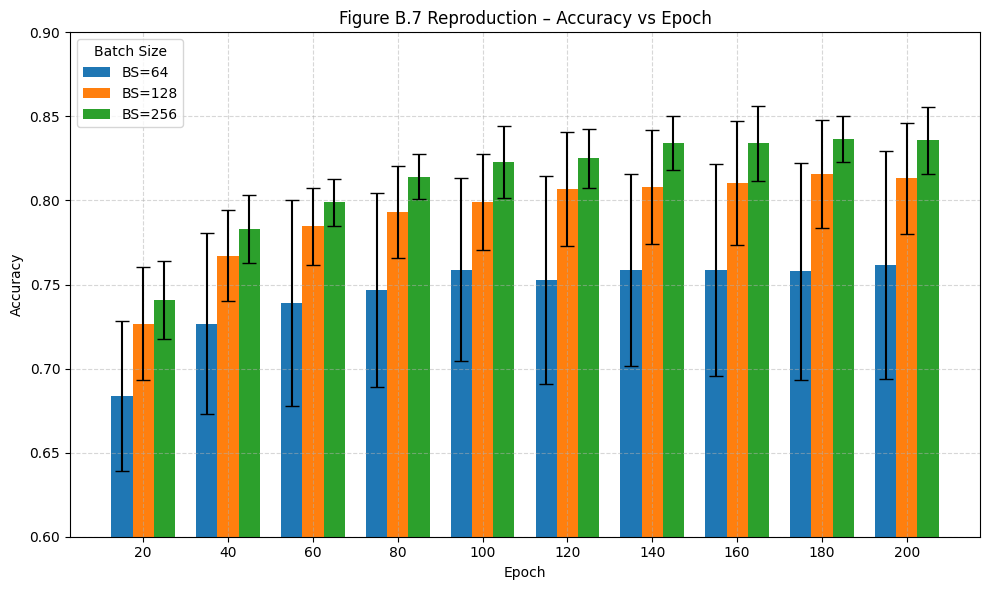

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load results
csv_path = '/content/drive/My Drive/ECE 661/Project/eval_results.csv'
df = pd.read_csv(csv_path)

# Filter out epoch 1
df = df[df['epoch'] != 1]

# Ensure sorted ordering
df = df.sort_values(by=["epoch", "batch_size", "learning_rate"])
epochs = sorted(df['epoch'].unique())
batch_sizes = sorted(df['batch_size'].unique())
bar_width = 0.25
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Setup plot
plt.figure(figsize=(10, 6))
x = np.arange(len(epochs))  # x-ticks for each epoch (excluding 1)

# Plot one bar per batch size per epoch (mean ± std across learning rates)
for i, bs in enumerate(batch_sizes):
    means = []
    stds = []
    for ep in epochs:
        subset = df[(df['epoch'] == ep) & (df['batch_size'] == bs)]
        means.append(subset['accuracy'].mean())
        stds.append(subset['accuracy'].std())

    x_offset = x + i * bar_width
    plt.bar(x_offset, means, yerr=stds, width=bar_width, label=f'BS={bs}',
            color=colors[i], capsize=5)

# Labels and aesthetics
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Figure B.7 Reproduction – Accuracy vs Epoch")
plt.xticks(x + bar_width, epochs)
plt.legend(title='Batch Size')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0.6, 0.9)
plt.tight_layout()

# Save + show
plt.savefig("figure_b7_grouped_by_epoch_excl_ep1.png")
plt.show()
